In [1]:
import os
import tarfile

# from torch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# from torchvision

import torchvision
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid

# other utilities 

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

Using downloaded and verified file: .\cifar10.tgz
['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [19]:
!tree data/cifar10

Folder PATH listing for volume Work Files
Volume serial number is 000000BA 200C:D66F
E:\CODES\MACHINE_LEARNING\DEEP_LEARNING\PYTORCH_BASIC\DATA\CIFAR10
ÃÄÄÄtest
³   ÃÄÄÄairplane
³   ÃÄÄÄautomobile
³   ÃÄÄÄbird
³   ÃÄÄÄcat
³   ÃÄÄÄdeer
³   ÃÄÄÄdog
³   ÃÄÄÄfrog
³   ÃÄÄÄhorse
³   ÃÄÄÄship
³   ÀÄÄÄtruck
ÀÄÄÄtrain
    ÃÄÄÄairplane
    ÃÄÄÄautomobile
    ÃÄÄÄbird
    ÃÄÄÄcat
    ÃÄÄÄdeer
    ÃÄÄÄdog
    ÃÄÄÄfrog
    ÃÄÄÄhorse
    ÃÄÄÄship
    ÀÄÄÄtruck


In [4]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

## Converting  all the images and their labels( folder name) to pytorch dataset dataset

In [5]:
train_ds = ImageFolder(data_dir+"/train",train_tfms)
valid_ds = ImageFolder(data_dir+"/test",valid_tfms)

In [6]:
batch_size = 400 

In [7]:
# Converting data sets to data loader

train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
valid_loader = DataLoader(valid_ds,batch_size*2,num_workers = 2, pin_memory = True)

In [8]:
def show_batch(dl):
    for images , labels in dl:
        fig, ax = plt.subplots(figsize = (12,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow = 8).permute(1,2,0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


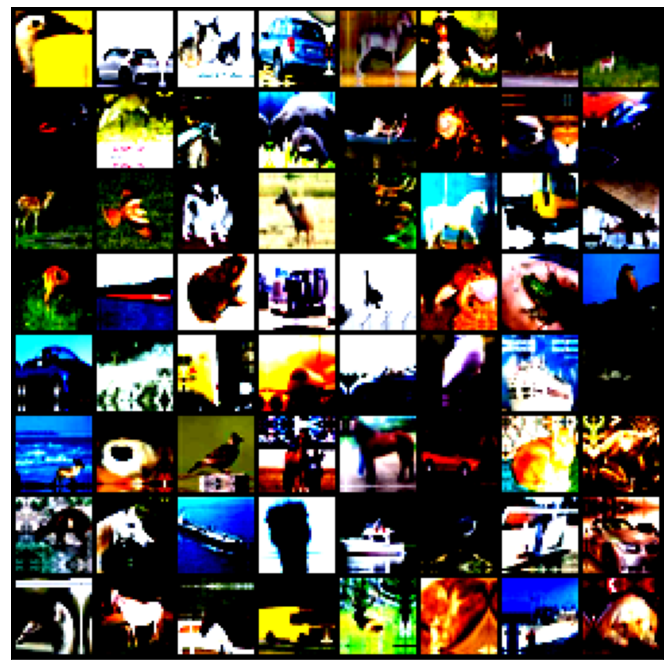

In [9]:
show_batch(train_loader)

### Getting gpu ready 

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

### taking the data to the device

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_loader = DeviceDataLoader(train_loader,device)
valid_loader = DeviceDataLoader(valid_loader, device)

## Defining Simple Residual Block

In [13]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(3,3,kernel_size=3, stride = 1, padding = 1)
        self.relu_1 = nn.ReLU()
        self.conv_2 = nn.Conv2d(3,3,kernel_size=3, stride = 1, padding=1)
        self.relu_2 = nn.ReLU()
        
    def forward(self , x):
        out  = self.conv_1(x)
        out = self.relu_1(out)
        out = self.conv_2(out)
        
        return self.relu_2(out)+x

In [14]:
simple_resnet  = to_device(SimpleResidualBlock(), device)

for images , labels in train_loader :
    print(images.shape)
    out = simple_resnet(images)
    print(out.shape)
    break
    
    
del simple_resnet , images, labels

torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])
torch.Size([400, 3, 32, 32])


In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
def conv_block(in_channels, out_channels, pool = False):
    layers = [nn.Conv2d(in_channels, out_channels , kernel_size=3, padding = 1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace = True)]
    
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


# defining a restnet model with restnet 9 Architecture

class RestNet9(ImageClassificationBase):
    def __init__(self , in_channels, num_classes):
        super().__init__()
        
        self.conv_1 = conv_block(in_channels, 64)        # 64x32x32
        self.conv_2 = conv_block(64, 128 , pool = True)  # 128 x16x16
        self.rest_1 = nn.Sequential(conv_block(128,128),conv_block(128,128)) # 128 x16x16
        
        self.conv_3 = conv_block(128,256,pool = True)   # 256 x 8x8
        self.conv_4 = conv_block(256,512 , pool = True) #  512 x4x4
        self.rest_2 = nn.Sequential(conv_block(512,512),conv_block(512,512))   # 512 x4x4
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), # 512x1x1
                                       nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512,num_classes))
        
        
    def forward(self, xb):
        
        out = self.conv_1(xb)           
        out = self.conv_2(out)       
        out = self.rest_1(out) + out
        out = self.conv_3(out)
        out = self.conv_4(out)
        out = self.rest_2(out) +out
        out = self.classifier(out)
        
        return out
        
        
        
        
    

In [18]:
model = to_device(RestNet9(3,10) , device)
model

RestNet9(
  (conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (rest_1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpla

In [21]:
# defining fit function


@torch.no_grad()

def evalute(model, valid_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_dl]
    return model.validation_epoch_end(outputs)



def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

    
def fit_one_cycle(epochs, max_lr, train_loader, valid_loader, weight_decay = 0 , grad_clip = None , opt_func = torch.optim.SGD):
    
    
    torch.cuda.empty_cache()
    
    history = []
    
    # setting up custom optimizer with weight decay 
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
    
    # set up one cycle learning rate scheduler 
    
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs = epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in tqdm(range(epochs)):
        # training phase 
        
        model.train()
        
        train_losses = []
        lrs = []
        
        for batch in train_loader:
            
            loss = model.training_step()
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping 
            
            if grad_clip: 
                
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            
            # record and update learning rate 
            
            lrs.append(get_lr(optimizer))
            sched.step()
            
            
        # Validation step 
        
        result = evalute(model, valid_loader)
        
        result['train_loss']  = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [22]:
# evaluation before training

history = [evalute(model, valid_loader)]
history

RuntimeError: CUDA out of memory. Tried to allocate 400.00 MiB (GPU 0; 2.00 GiB total capacity; 658.24 MiB already allocated; 90.62 MiB free; 1.04 GiB reserved in total by PyTorch)